# Ridge Regression

This note introduces the **Ridge Regression** algorithm using `scikit-learn`, explains the step-by-step logic behind how it works, and then demonstrates a from-scratch implementation to show that the core idea is simple and easy to build.

## What is Ridge Regression?

Ridge Regression is like **Linear Regression with a safety net**.

It still tries to draw the best straight line through the data, but it also **penalizes large coefficients** to prevent the model from overfitting. This makes it more robust, especially when the data is noisy or when features are highly correlated.

It adds a small "cost" for having large weight values — which keeps the model simpler and more generalizable.

This notebook will:

- Use `scikit-learn` to demonstrate how Ridge Regression works in practice  
- Explain the logic behind it in an intuitive way  
- Show how to implement the same idea step by step from scratch  

Let’s dive into the details to understand how it works and how to implement it ourselves.

## Preparation
Before we apply Ridge Regression, let’s create a dataset that has a **nonlinear trend** and some **random noise** — so we can see how regularization helps prevent overfitting.

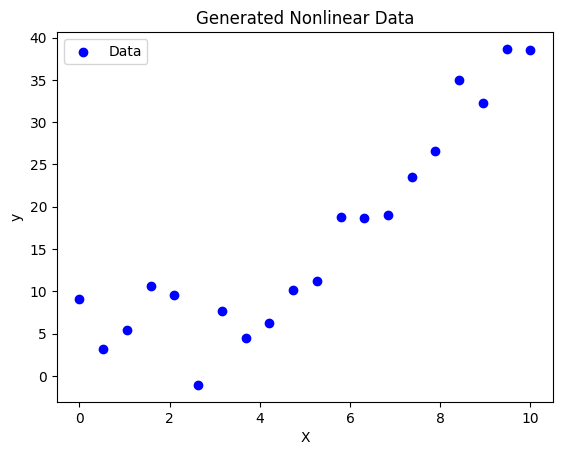

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create nonlinear data
np.random.seed(0)
X = np.linspace(0, 10, 20).reshape(-1, 1)
y = 0.5 * X**2 - X + 2 + np.random.randn(20, 1) * 4  # add noise

# Visualize the data
plt.scatter(X, y, color='blue', label='Data')
plt.title("Generated Nonlinear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Implement with Scikit-Learn

We’ll now use `scikit-learn` to fit a **Ridge Regression model** on a **small, noisy dataset**.

Because the relationship is nonlinear, we’ll first expand the input features using **PolynomialFeatures**. Then we’ll apply **Ridge Regression** to see how regularization helps prevent overfitting — especially with high-degree polynomials and limited data.

We’ll compare two models:

- A standard **Polynomial Regression** (which tends to overfit with small data)
- A **Ridge-regularized Polynomial Regression** (which smooths the curve)

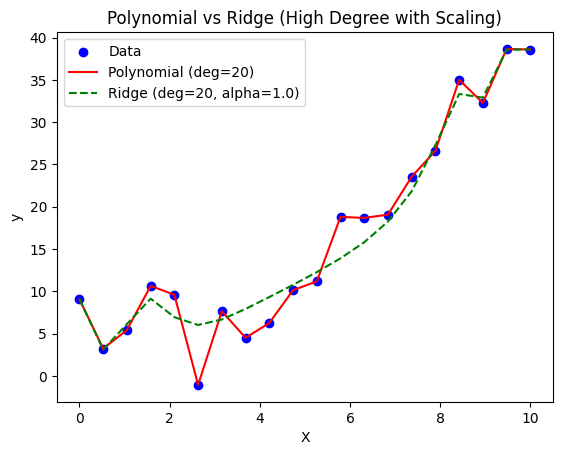

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

degree = 20

# Without Ridge (standard polynomial)
poly_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), LinearRegression())
poly_model.fit(X, y)
y_pred_poly = poly_model.predict(X)

# With Ridge (strong regularization)
ridge_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree), Ridge(alpha=1.0))
ridge_model.fit(X, y)
y_pred_ridge = ridge_model.predict(X)

# Plot
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred_poly, color='red', label='Polynomial (deg=20)')
plt.plot(X, y_pred_ridge, color='green', linestyle='--', label='Ridge (deg=20, alpha=1.0)')
plt.title("Polynomial vs Ridge (High Degree with Scaling)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Understanding the Visualization

The plot above shows how two models behave when trained on just **20 data points** with visible noise.

- The red line is **standard Polynomial Regression** (degree 20)
- The green dashed line is **Polynomial + Ridge Regression** (degree 20, alpha=1.0)

Both models use the same high-degree polynomial, but Ridge applies **regularization** to keep the curve smoother and prevent it from overfitting the noise in the data.

## Behind the Scenes

### 1. Polynomial Features = Curve-Friendly Input

A normal linear model like:

$$
\hat{y} = w_0 + w_1 x
$$

can only fit a straight line. To model curves, we expand the input:

$$
x \rightarrow [1, x, x^2, x^3, \dots, x^d]
$$

So the model becomes:

$$
\hat{y} = w_0 + w_1 x + w_2 x^2 + \dots + w_d x^d
$$

This gives the model more flexibility to follow curved patterns in the data.

Even though the output is nonlinear in $x$, it is still **linear in the weights**, so we can train it using the same techniques as linear regression.

### 2. Why Regularization?

With just 20 points and a 20-degree polynomial, the model can easily **overfit** — twisting and turning to match every point, even the noisy ones.

**Ridge Regression** prevents this by adding a **penalty** to the training process.  
This penalty gets larger when the model uses **big weights**.

So instead of just minimizing prediction error, the model now minimizes:

$$
\text{Loss} = \frac{1}{2n} \sum_{i=1}^n (\hat{y}_i - y_i)^2 + \frac{\alpha}{2} \sum_{j=1}^d w_j^2
$$

This added term:

$$
\frac{\alpha}{2} \sum w_j^2
$$

is what **encourages smaller weights**. Big weights lead to a big penalty. Small weights keep the loss low.

This is the heart of **regularization**.

### 3. How does it push the weights?

Ridge adds a **shrink force** during training to stop weights from growing too big.

If we use **gradient descent**, each weight is updated like this:

$$
w_j := w_j - \eta \cdot \left( \text{error gradient} + \alpha \cdot w_j \right)
$$

Let’s break it down:

- $ \text{error gradient} $ is the usual part that comes from prediction error  
- $ + \alpha \cdot w_j $ is the **new Ridge penalty** that pulls the weight back toward zero  
- $ \eta $ is the learning rate

So the model does two things at once:
1. Adjusts the weight to reduce prediction error  
2. **Pulls it back** toward zero if it's getting too large

> The bigger the weight, the stronger the pull — so large weights shrink faster.

This small shrink every step keeps the model from becoming too wiggly — especially when fitting high-degree polynomials.

If we use the **closed-form solution** instead of gradient descent, Ridge modifies the normal equation.

Normally, we solve for the weights with:

$$
\mathbf{w} = (X^\top X)^{-1} X^\top y
$$

But Ridge adds a penalty directly into the matrix:

$$
\mathbf{w} = (X^\top X + \alpha I)^{-1} X^\top y
$$

- $X$ is the matrix of features (including $x$, $x^2$, etc.)  
- $I$ is the identity matrix  
- $\alpha$ controls how strong the shrink is

This makes the matrix easier to invert and the weights smaller — especially when features are highly correlated or the data is noisy.

> Whether we use gradient descent or the closed-form solution, Ridge always works by **gently shrinking** the weights to improve stability and reduce overfitting.

### 4. What happens when weights get smaller?

Each weight controls how much the model curves:

- $w_1$ controls the slope  
- $w_2$ controls the curve  
- $w_3$, $w_4$, and higher degrees control twists and wiggles  

If the weights are big, the model swings wildly — trying to hit every data point exactly.

But when Ridge keeps the weights **small**:
- The curve becomes **smoother**
- The shape stays closer to the **middle of the data**
- It focuses on the **overall pattern**, not the noise

So instead of chasing every random bump in the data, Ridge helps the model **stay calm and centered**.

## Let's Code It

Now let’s implement **Polynomial Regression with Ridge Regularization** from scratch,  
using the **closed-form solution** (Normal Equation with regularization) we discussed earlier.

We’ll follow two main steps:

1. Expand the input into **polynomial features**  
2. Solve for the weights using the **Ridge-modified normal equation**:

$$
\mathbf{w} = (X^\top X + \alpha I)^{-1} X^\top y
$$

This gives the weights that **both fit the data and stay small**, helping to avoid overfitting.

/var/folders/tr/yjf92mb96zv54kl6xmrr87ym0000gn/T/ipykernel_68572/2889701849.py:27: RuntimeWarning: overflow encountered in matmul
  gradient = (1 / n_samples) * X_poly.T @ error
/var/folders/tr/yjf92mb96zv54kl6xmrr87ym0000gn/T/ipykernel_68572/2889701849.py:25: RuntimeWarning: overflow encountered in matmul
  y_pred = X_poly @ self.coef_
/var/folders/tr/yjf92mb96zv54kl6xmrr87ym0000gn/T/ipykernel_68572/2889701849.py:25: RuntimeWarning: invalid value encountered in matmul
  y_pred = X_poly @ self.coef_


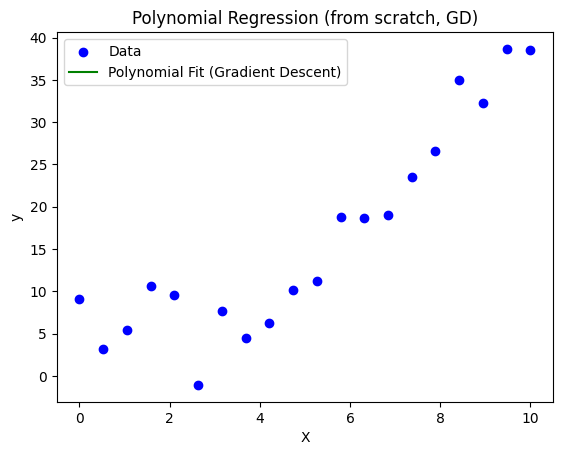

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Expand input into polynomial features
def add_polynomial_features(X, degree):
    """
    Expand input X into [1, x, x^2, ..., x^d]
    Mentioned in: '1. Polynomial Features = Curve-Friendly Input'
    """
    return np.hstack([X**d for d in range(degree + 1)])

# Step 2: Fit using Ridge-regularized closed-form solution
class MyRidgePolynomialRegression:
    def __init__(self, degree=2, alpha=1.0):
        self.degree = degree
        self.alpha = alpha
        self.coef_ = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        """
        Fit using: w = (XᵀX + αI)^(-1) Xᵀy
        Mentioned in: '3. Closed-Form Ridge Equation'
        We scale X_poly to stabilize large values like x^20
        """
        X_poly = add_polynomial_features(X, self.degree)
        X_scaled = self.scaler.fit_transform(X_poly)

        n_features = X_scaled.shape[1]
        I = np.eye(n_features)
        I[0, 0] = 0  # Do not regularize the bias term

        self.coef_ = np.linalg.pinv(X_scaled.T @ X_scaled + self.alpha * I) @ X_scaled.T @ y

    def predict(self, X):
        """
        Apply same scaling to test data before prediction
        """
        X_poly = add_polynomial_features(X, self.degree)
        X_scaled = self.scaler.transform(X_poly)
        return X_scaled @ self.coef_

# Prediction grid for smoother curve
X_test = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)

# Train the model
model = MyRidgePolynomialRegression(degree=20, alpha=1.0)
model.fit(X, y)
y_pred = model.predict(X_test)

# Plot result
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X_test, y_pred, color='green', label='Ridge Poly Fit (deg=20, α=1.0)')
plt.title("Polynomial Regression with Ridge (from scratch)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()